#Trabalho Final - Machine Learning - Bootcamp ENAP 2020

## Apresentação

Construção de modelo de regressão linear que pode ser utilizado para previsão de gastos com passagens aéreas nos diversos órgãos da administração pública.

## Equipe

Cristhiano Mello - Justiça Federal do Paraná

Edson Dario Silva de França - Departamento Penitenciário Nacional (DEPEN/MJSP)

Eluzaí Souza dos Santos - Tribunal Regional Federal da 1ª Região

Rafael Ventura da Silva - Polícia Rodoviária Federal

## Link para download do dataset: 

https://www.kaggle.com/zernach/2018-airplane-flights

## Importação de bibliotecas

In [3]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Modelo de regressão linear
from sklearn.linear_model import LinearRegression

# Normalização das variáveis
from sklearn.preprocessing import StandardScaler

# Variáveis categóricas
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Biblioteca de gráficos
import seaborn as sns
from matplotlib import pyplot as plt

# Imprimir gráficos no caderno
%matplotlib inline

# Validação cruzada
from sklearn.model_selection import cross_val_score, cross_validate

import statsmodels.api as sm

from sklearn.linear_model import ElasticNet

# Usado no statsmodel para gerar métricas
from statsmodels.tools.eval_measures import meanabs

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Análise exploratória dos dados

### Carregamento dos dados

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Criar atalho no drive pessoal.

# path = '/content/drive/MyDrive/dados/Cleaned_2018_Flights.csv'
path = '/content/drive/MyDrive/dados/10000-linhas.csv'

# df_pass = pd.read_csv(path, index_col='Unnamed: 0')
df_pass = pd.read_csv(path)
df_pass

,MktCoupons,Quarter,Origin,OriginWac,Dest,DestWac,Miles,ContiguousUSA,NumTicketsOrdered,AirlineCompany,PricePerTicket
0,1,2,EWR,21,MCO,33,937.0,2,3.0,WN,133.50
1,1,1,BOS,13,MKE,45,860.0,2,1.0,WN,124.50
2,1,4,IND,42,LAS,85,1590.0,2,1.0,WN,656.47
3,1,1,ORD,41,MSY,72,837.0,2,1.0,UA,705.00
4,1,3,FLL,33,BOS,13,1237.0,2,1.0,WN,170.58
...,...,...,...,...,...,...,...,...,...,...,...
9995,1,3,LAS,85,EWR,21,2227.0,2,2.0,UA,170.00
9996,1,2,CLE,44,TPA,33,927.0,2,14.0,F9,99.00
9997,1,2,IAD,38,SAT,74,1362.0,2,2.0,F9,94.50
9998,1,2,SEA,93,ORD,41,1721.0,2,4.0,UA,232.00


In [6]:
# Exclusão de colunas

# del df_pass['ItinID']
# del df_pass['MktID']
del df_pass['OriginWac']
del df_pass['DestWac']
del df_pass['ContiguousUSA']
del df_pass['MktCoupons']

In [7]:
# Verificação dos dados das colunas

# df_pass.Origin.unique()
# df_pass.Dest.unique()
# df_pass.AirlineCompany.unique()

# Verificação de dados faltantes
# df_pass.isnull().sum().sort_values(ascending = False)

In [8]:
df_pass

,Quarter,Origin,Dest,Miles,NumTicketsOrdered,AirlineCompany,PricePerTicket
0,2,EWR,MCO,937.0,3.0,WN,133.50
1,1,BOS,MKE,860.0,1.0,WN,124.50
2,4,IND,LAS,1590.0,1.0,WN,656.47
3,1,ORD,MSY,837.0,1.0,UA,705.00
4,3,FLL,BOS,1237.0,1.0,WN,170.58
...,...,...,...,...,...,...,...
9995,3,LAS,EWR,2227.0,2.0,UA,170.00
9996,2,CLE,TPA,927.0,14.0,F9,99.00
9997,2,IAD,SAT,1362.0,2.0,F9,94.50
9998,2,SEA,ORD,1721.0,4.0,UA,232.00


In [9]:
df_pass.describe()

,Quarter,Miles,NumTicketsOrdered,PricePerTicket
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,2.560700,1194.014400,2.431700,231.158151
std,1.116799,696.235246,2.940408,142.572046
min,1.000000,41.000000,1.000000,50.000000
25%,2.000000,679.000000,1.000000,134.000000
50%,3.000000,1020.000000,1.000000,196.000000
75%,4.000000,1608.000000,2.000000,288.000000
max,4.000000,5071.000000,20.000000,997.000000


### Avaliação visual dos dados

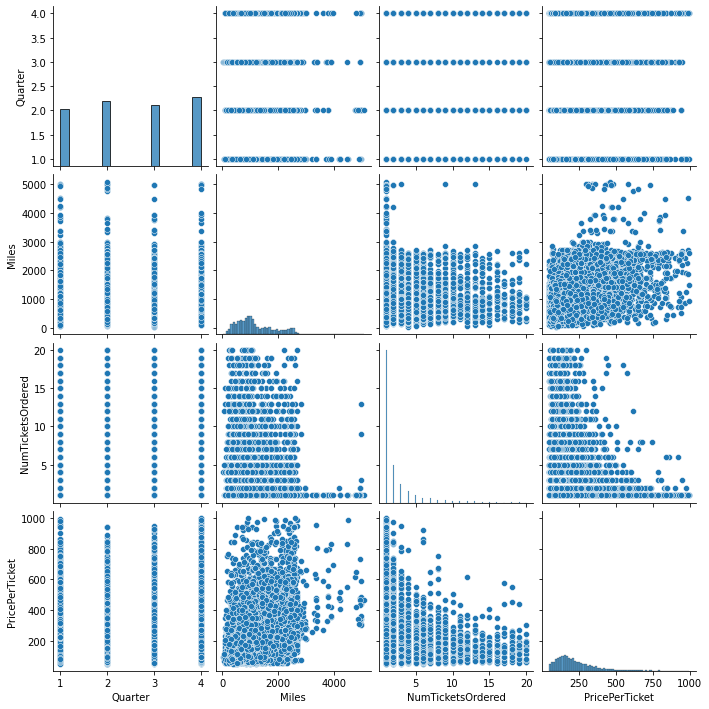

In [10]:
# Relação entre as variáveis numéricas (NumTicketsOrdered, Miles e Quarter) e o target
sns.pairplot(df_pass)

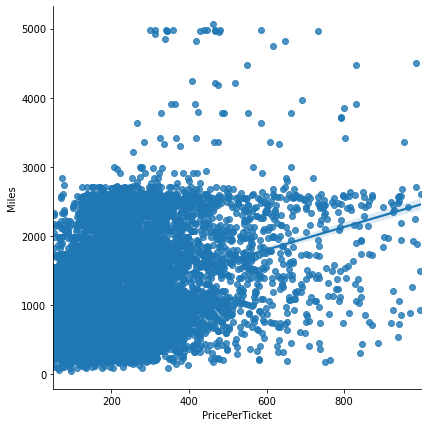

In [11]:
# Relação entre a variável miles e o target

# Cópia do dataframe original para conversão da escala
df_pass_graph = df_pass.copy() 
# Conversão da escala para log, criando duas novas colunas
df_pass_graph['Miles_log'] = np.log(df_pass_graph['Miles'])
df_pass_graph['PricePerTicket_log'] = np.log(df_pass_graph['PricePerTicket'])

sns.pairplot(df_pass_graph, x_vars=['PricePerTicket'], y_vars='Miles', height=6, aspect=1, kind='reg');

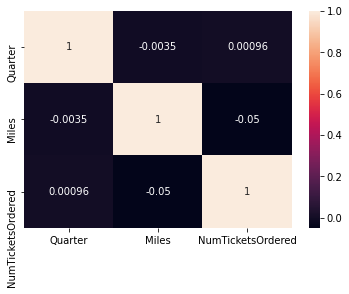

In [12]:
# Matriz de correlação

# Define o dataframe
X_statsmodels = df_pass[['Quarter', 'Origin', 'Dest', 'Miles', 'NumTicketsOrdered', 'AirlineCompany']]
y_statsmodels = df_pass.PricePerTicket

correlacao = X_statsmodels.corr()
sns.heatmap(correlacao, xticklabels=correlacao.columns, yticklabels=correlacao.columns, annot=True)

## Preparação dos dados

In [13]:
# Variáveis independentes
X = df_pass.iloc[:,:-1]
# Target - Variável dependente
y = df_pass['PricePerTicket']

In [14]:
# Dimensões do dataset
print(X.shape)
print(y.shape)

(10000, 6)
(10000,)


In [15]:
# Separação dos dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.2)

In [16]:
print('Dimensão dos dados de treino')
print('X:', X_train.shape)
print('y:', y_train.shape)
print('Dimensão dos dados de teste')
print('X:', X_test.shape)
print('y:', y_test.shape)

Dimensão dos dados de treino
X: (8000, 6)
y: (8000,)
Dimensão dos dados de teste
X: (2000, 6)
y: (2000,)


## Pré-processamento

In [17]:
# Lista com nomes das features
feature_cols_category = ['AirlineCompany', 'Quarter', 'Origin', 'Dest']
feature_cols_padroniza = ['Miles', 'NumTicketsOrdered']

In [18]:
# Definição do proprocessador: objeto que agrupa os processos de padronização (normalização) e categorização
preprocessor = ColumnTransformer( 
    transformers=[        
        ('integer', StandardScaler(), feature_cols_padroniza), # Padronização deve ser feita antes do OneHotEncoder. Especifica as colunas que serão padronizadas.     
        ('category', OneHotEncoder(handle_unknown='ignore'), feature_cols_category) # Especifica as colunas categóricas.   
    ], remainder='passthrough')


In [19]:
X_train = preprocessor.fit_transform(X_train)

# Dimensões dos dados de treino
X_train.shape

(8000, 397)

In [20]:
X_test_orig = X_test
X_test = preprocessor.transform(X_test)

# Dimensões dos dados de teste
X_test.shape

(2000, 397)

In [21]:
X_train

<8000x397 sparse matrix of type '<class 'numpy.float64'>'
	with 48000 stored elements in Compressed Sparse Row format>

## Treino do modelo

In [22]:
# Instanciação do modelo de regressão linear
lr = LinearRegression()

In [23]:
# Treino do modelo (aprende os coeficientes)
modelo = lr.fit(X_train, y_train)

In [24]:
lr.score(X_train, y_train)

0.29005164649339454

## Interpretação dos coeficientes

In [25]:
print('intercept_: ',lr.intercept_)
print(lr.coef_)

intercept_:  215.5233383692261
[  44.56075976  -19.3860297    57.45214949   30.33823164   31.81603482
   68.33663237  -82.77871163  -69.13051478   -7.15371208  -93.4610551
  -44.47308343   73.77547815   14.78113398   20.49741656    0.31142623
   -1.31412053   -3.71705836    4.71975266   -0.71595327  -34.14596662
  -41.46947456   41.61491861   -4.18405749    7.2285748    27.45074341
  -22.12339872    3.00757927  -19.06681467   -1.30877714  -26.1654212
    1.34669995    9.88079774  -45.23687611   85.65417544    4.14316098
  -65.64370379   19.81298111   21.12309262   -8.30190328  -57.47742857
  -14.33496402  -10.86350725  -25.22377019 -108.69976465  140.15913341
  -21.37994502  -12.82390232  -21.99290913  -19.3002674  -129.16649484
   -0.90400798  -35.1181144    46.02931785  -26.17938942   -1.65036181
   36.7634008    -2.37522601   37.94084581  -64.80675933   -1.05863262
  -64.0561093   -23.24459745  -44.63772654   30.7179769   -18.39772374
   28.55276041  -75.87332355  -49.1431609     1.

In [26]:
# Feature names com coeficiente
feature_cols = ['Quarter', 'Origin', 'Dest', 'Miles', 'NumTicketsOrdered', 'AirlineCompany']
list(zip(feature_cols, lr.coef_))

[('Quarter', 44.560759758897504),
 ('Origin', -19.386029697505716),
 ('Dest', 57.452149492474234),
 ('Miles', 30.338231642509353),
 ('NumTicketsOrdered', 31.81603482044097),
 ('AirlineCompany', 68.3366323684896)]

## Testar o modelo (inferência)

In [27]:
# Predição do preço de passagem aérea
y_predict = lr.predict(X_test)
y_predict

array([233.26322552, 244.97438588, 165.55498118, ..., 156.09787724,
       326.96316929, 138.46460587])

#### Resíduos

In [28]:
# Resíduos
residuo = y_test - y_predict
print('Média do resíduo: ', round(residuo.mean()))
print('Desvio padrão: ', round(residuo.std(),3))

Média do resíduo:  -2
Desvio padrão:  124.58


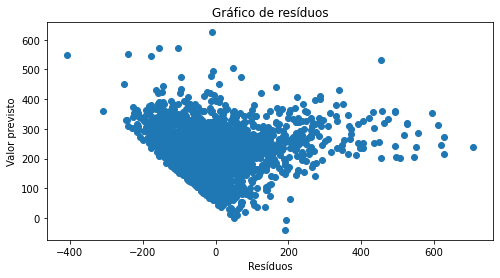

In [29]:
# Gráfico de resíduos
plt.figure(figsize=(8,4))
plt.scatter(residuo, y_predict)
plt.title("Gráfico de resíduos")
plt.xlabel("Resíduos")
plt.ylabel("Valor previsto")
plt.show()

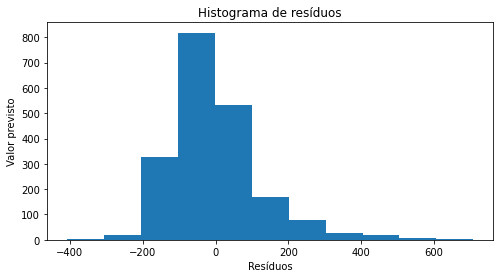

In [30]:
# Gráfico de resíduos
plt.figure(figsize=(8,4))
plt.hist(residuo, bins= 11)
plt.title("Histograma de resíduos")
plt.xlabel("Resíduos")
plt.ylabel("Valor previsto")
plt.show()

## Avaliar qualidade do modelo

In [31]:
metrics.r2_score(y_test, y_predict) # Explicação do algoritmo quanto aos dados.

0.2312014972723465

RMSE  
Erro médio quadrático da raiz (RMSE) é a raiz quadrada da média dos erros quadráticos.

In [33]:
metrics.mean_squared_error(y_test, y_predict)

15517.791311751496

In [34]:
metrics.mean_absolute_error(y_test, y_predict) # Margem de erro. Soma todos os valores de erros (para mais ou menos)

90.81027209457416

## Teste retirando algumas variáveis independentes

In [35]:
feature_cols = ['AirlineCompany', 'Origin', 'Dest']

# Atribui a X um subconjunto do dataframe
X_novo = df_pass[feature_cols].copy()

# Target
y_novo = df_pass['PricePerTicket'].copy()

# Divide o dataset em treino e teste
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_novo, y_novo, random_state=42, test_size=0.2)

# Definição do proprocessador: objeto que agrupa os processos de padronização (normalização) e categorização
preprocessor_novo = ColumnTransformer( 
    transformers=[        
        ('category', OneHotEncoder(handle_unknown='ignore'), feature_cols) # Especifica as colunas categóricas.   
    ], remainder='passthrough')

X_train_n = preprocessor_novo.fit_transform(X_train_n)
X_test_n = preprocessor_novo.transform(X_test_n)

# Instanciação do modelo de regressão linear
lr_novo = LinearRegression()

# Treino do modelo
lr_novo.fit(X_train_n, y_train_n)

# Predição para os dados do novo subconjunto
y_pred = lr_novo.predict(X_test_n)

In [36]:
# Cálculo do RMSE
print(np.sqrt(metrics.mean_squared_error(y_test_n, y_pred)))
metrics.mean_absolute_error(y_test_n, y_pred)

131.0801371056117


95.82733655675335

## ElasticNet

In [37]:
# Elasticnet => Regressor que diminui a rede de parâmetros para diminuir o ruído.

en = ElasticNet(l1_ratio=0)
en.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:460: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74763539.93448235, tolerance: 16287.637525699358
  max_iter, tol, rng, random, positive)


ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [38]:
# y_predict_en = en.predict(preprocessor.transform(X_test))
y_predict_en = en.predict(X_test)

In [39]:
metrics.r2_score(y_test, y_predict_en) # Abaixo de 0.5 => Modelo não é apropriado.

0.12911195061740333

In [40]:
metrics.mean_squared_error(y_test, y_predict_en) # Erro quadrático médio

17578.414835967607

In [41]:
metrics.mean_absolute_error(y_test, y_predict) # Margem de erro. Soma todos os valores de erros (para mais ou menos)

90.81027209457416

In [42]:
lr.intercept_ # Se não informar valores das variáveis independentes este valor será mostrado.

215.5233383692261

In [43]:
lr.coef_ # Mostra o coeficiente de cada coluna após a execução do preprocessor.

array([  44.56075976,  -19.3860297 ,   57.45214949,   30.33823164,
         31.81603482,   68.33663237,  -82.77871163,  -69.13051478,
         -7.15371208,  -93.4610551 ,  -44.47308343,   73.77547815,
         14.78113398,   20.49741656,    0.31142623,   -1.31412053,
         -3.71705836,    4.71975266,   -0.71595327,  -34.14596662,
        -41.46947456,   41.61491861,   -4.18405749,    7.2285748 ,
         27.45074341,  -22.12339872,    3.00757927,  -19.06681467,
         -1.30877714,  -26.1654212 ,    1.34669995,    9.88079774,
        -45.23687611,   85.65417544,    4.14316098,  -65.64370379,
         19.81298111,   21.12309262,   -8.30190328,  -57.47742857,
        -14.33496402,  -10.86350725,  -25.22377019, -108.69976465,
        140.15913341,  -21.37994502,  -12.82390232,  -21.99290913,
        -19.3002674 , -129.16649484,   -0.90400798,  -35.1181144 ,
         46.02931785,  -26.17938942,   -1.65036181,   36.7634008 ,
         -2.37522601,   37.94084581,  -64.80675933,   -1.05863

## Validação cruzada (Cross validation)

In [44]:
result = cross_validate(lr, preprocessor.fit_transform(X), y, cv=10, scoring='r2', return_estimator=True)
# result = cross_validate(lr, X_train, y_train, cv=10, scoring='r2', return_estimator=True)
# result

In [45]:
# Imprimir score e identificar o índice do melhor score (maior valor)
result['test_score']

array([0.27317609, 0.26389215, 0.21880195, 0.20394735, 0.23720217,
       0.2403194 , 0.22316839, 0.26046348, 0.22746557, 0.24434676])

In [46]:
result['test_score'].mean()

0.2392783320128325

In [47]:
# Obter melhor modelo, selecionando através do índice do array de score.
# melhor_modelo = result['estimator'][0]
melhor_modelo = result['estimator'][0]

In [48]:
# Predição com o melhor modelo
y_predict_2 = melhor_modelo.predict(preprocessor.transform(X_test_orig))
metrics.r2_score(y_test, y_predict_2)

0.2750621881287689

## Statsmodels

In [49]:
# Utilizando preprocessador (padronização e OneHotEnconder)
X_statsmodels = preprocessor.fit_transform(X_statsmodels)
X_statsmodels = sm.add_constant(X_statsmodels.toarray())

In [50]:
model = sm.OLS(y, X_statsmodels).fit()

In [51]:
print(model.rsquared) # Abaixo de 0.5 => Modelo não é apropriado.

0.28425574254513364


In [52]:
print(model.mse_model) # Mean squared error

142301.19427760283


In [53]:
meanabs(y, model.predict(X_statsmodels)) # Mean absolute error -> Margem de erro. Soma todos os valores de erros (para mais ou menos)

86.0396071646893

FIM